In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize']=(16, 8.27) #set graphs size to A4 dimensions
sns.set_style('darkgrid')
sns.set(font_scale = 1.4)

In [2]:
#import train and test set from UCI links

train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital_status', 'occupation','relationship',
              'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train.columns = col_labels
test.columns = col_labels


categorical features: 
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


numerical features: 
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


<ipython-input-3-abe041767e2a>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax=sns.heatmap(corr_train.corr(), cmap='RdYlGn',annot=True)


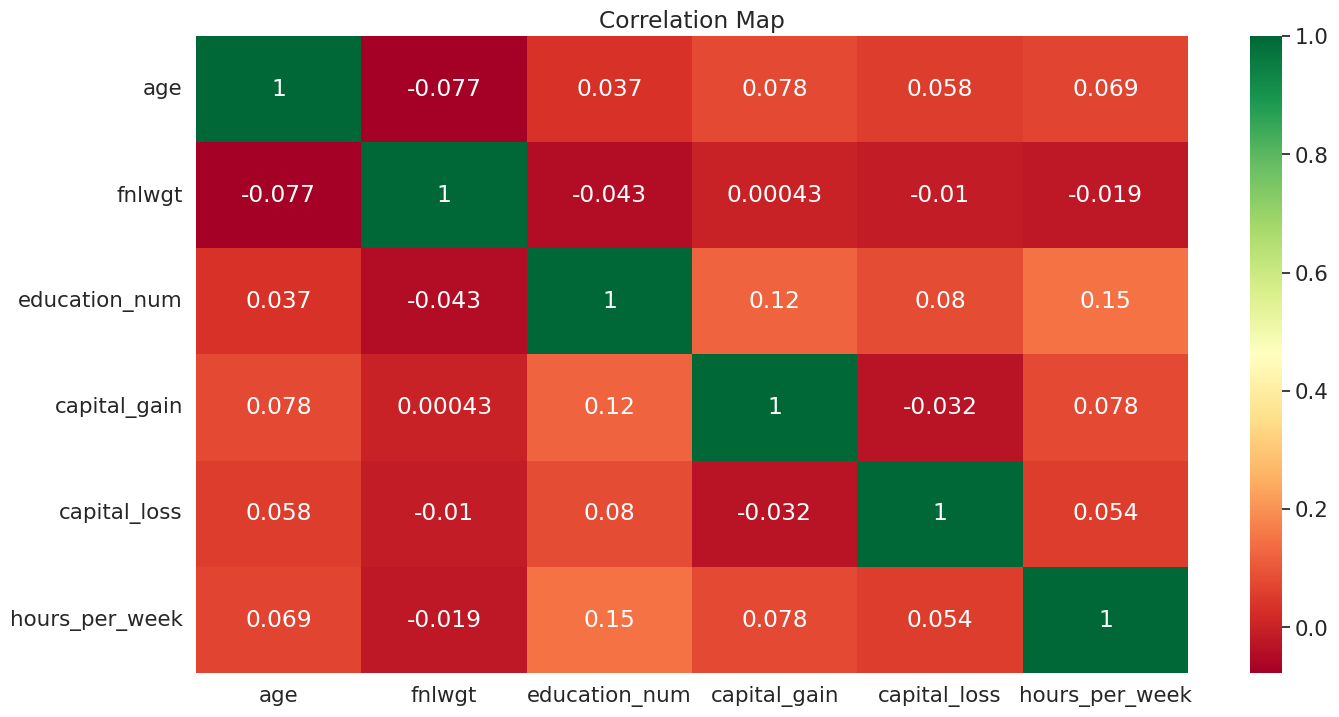

In [3]:
numerical_features=[feature for feature in train.columns if train[feature].dtype!='O']
categorical_features=[feature for feature in  train.columns if  train[feature].dtype=='O' and feature!='wage_class']

print('categorical features: ''\n',categorical_features)
print('\n')
print('numerical features: ''\n',numerical_features)

corr_train=train.copy()
for feature in categorical_features:
    corr_train.drop(feature,axis=1,inplace=True)


ax=sns.heatmap(corr_train.corr(), cmap='RdYlGn',annot=True)
ax.set_title('Correlation Map')
plt.show()

In [4]:
#convert <=50K and >50K to 0, 1 respectively
encoder=LabelEncoder()
train['wage_class']=encoder.fit_transform(train['wage_class'])


In [5]:
categorical_features=[feature for feature in  train.columns if  train[feature].dtype=='O' and feature!='wage_class']
for feature in categorical_features:
    freq=train[feature].value_counts().rename_axis(feature).reset_index(name='frequency')
    print('\n')
    print(freq)



           workclass  frequency
0            Private      22696
1   Self-emp-not-inc       2541
2          Local-gov       2093
3                  ?       1836
4          State-gov       1298
5       Self-emp-inc       1116
6        Federal-gov        960
7        Without-pay         14
8       Never-worked          7


        education  frequency
0         HS-grad      10501
1    Some-college       7291
2       Bachelors       5355
3         Masters       1723
4       Assoc-voc       1382
5            11th       1175
6      Assoc-acdm       1067
7            10th        933
8         7th-8th        646
9     Prof-school        576
10            9th        514
11           12th        433
12      Doctorate        413
13        5th-6th        333
14        1st-4th        168
15      Preschool         51


           marital_status  frequency
0      Married-civ-spouse      14976
1           Never-married      10683
2                Divorced       4443
3               Separated       1

In [6]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
train['native_country']=np.where(train['native_country']==' United-States',1,0)
#transform marital status and concatenate some classes to reduce distinct classes
train['marital_status']=train['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced',
                                                         ' Divorced':'Divorced',
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
train['workclass']=np.where(train['workclass']==' Private',1,0)
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
train['sex']=np.where(train['sex']==' Male',1,0)
#transform workclass feature to be 1 if the Race is White and 0 if doesn't
train['race']=np.where(train['race']==' White',1,0)
#create ordered label for education
education_mapping={' Preschool':0,' 1st-4th':1,' 5th-6th':2,' 7th-8th':3,' 9th':4,' 10th':5,
                   ' 11th':6,' 12th':7,' HS-grad':8,' Some-college':0,' Assoc-acdm':10,
                   ' Assoc-voc':11, ' Bachelors':12, ' Prof-school':13, ' Masters':14,' Doctorate':15
                   }
train['education']=train['education'].map(education_mapping)
relationship_ordered=train.groupby(['relationship'])['wage_class'].count().sort_values().index
relationship_ordered={k:i for i,k in enumerate(relationship_ordered,0)}
train['relationship']=train['relationship'].map(relationship_ordered)
occupation_ordered=train.groupby(['occupation'])['wage_class'].count().sort_values().index
occupation_ordered={k:i for i,k in enumerate(occupation_ordered,0)}
train['occupation']=train['occupation'].map(occupation_ordered)
marital_ordered=train.groupby(['marital_status'])['wage_class'].count().sort_values().index
marital_ordered={k:i for i,k in enumerate(marital_ordered,0)}
train['marital_status']=train['marital_status'].map(marital_ordered)
train.head(10)
train.drop('fnlwgt',axis=1,inplace=True) # it is not a useful feature for predicting the wage class
train['wage_class'].value_counts() #now train set is balanced
#scaling the train set with StandardScaler
scaler=StandardScaler()
scaled_features_train=scaler.fit_transform(train.drop('wage_class',axis=1))
scaled_features_train=pd.DataFrame(scaled_features_train, columns=train.drop('wage_class',axis=1).columns)
#undersampling the train set
under=OneSidedSelection()
X_train_res, y_train_res=under.fit_resample(scaled_features_train, train['wage_class'])


#oversampling the train set
sm=SMOTE()
X_train_res, y_train_res= sm.fit_resample(X_train_res, y_train_res)

X_train_res=pd.DataFrame(X_train_res, columns=train.drop('wage_class',axis=1).columns)



#creating the final train
final_train=pd.concat([X_train_res, y_train_res],axis=1)
final_train.head(10)
final_train['wage_class'].value_counts() #now train set is balanced
X=final_train.drop('wage_class',axis=1)
y=final_train['wage_class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import xgboost as xgb
import pandas as pd

# Assuming 'df' is your DataFrame containing the features and target.
"""X = df.drop('target', axis=1)
y = df['target']"""

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with PolynomialFeatures and XGBClassifier
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, interaction_only=True)),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [2, 3],  # To search for the best degree of interactions
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1]
}

# Set up GridSearchCV
grid_search_XG = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_XG.fit(X_train, y_train)

# Get the best combination of features
best_combination = grid_search_XG.best_estimator_.named_steps['poly'].get_feature_names_out(input_features=X.columns)
best_params = grid_search_XG.best_params_
best_score = grid_search_XG.best_score_

print(f"Best combination of features and interactions:\n{best_combination}")
print(f"Best parameters found: {best_params}")
print(f"Best accuracy achieved: {best_score}")

# Evaluate on the test set
test_score = grid_search_XG.score(X_test, y_test)
print(f"Test set accuracy: {test_score}")


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import xgboost as xgb
import pandas as pd


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with PolynomialFeatures and LogisticRegression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, interaction_only=True)),
    ('model', LogisticRegression())
])

# Parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [2, 3],  # To search for the best degree of interactions
    'model__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'model__penalty': ['l1', 'l2']  # Type of regularization
}

# Set up GridSearchCV with logistic regression
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Output the best settings and evaluate on the test set
best_combination = grid_search.best_estimator_.named_steps['poly'].get_feature_names_out(input_features=X.columns)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

print(f"Best combination of features and interactions:\n{best_combination}")
print(f"Best parameters found: {best_params}")
print(f"Best accuracy achieved: {best_score}")
print(f"Test set accuracy: {test_score}")


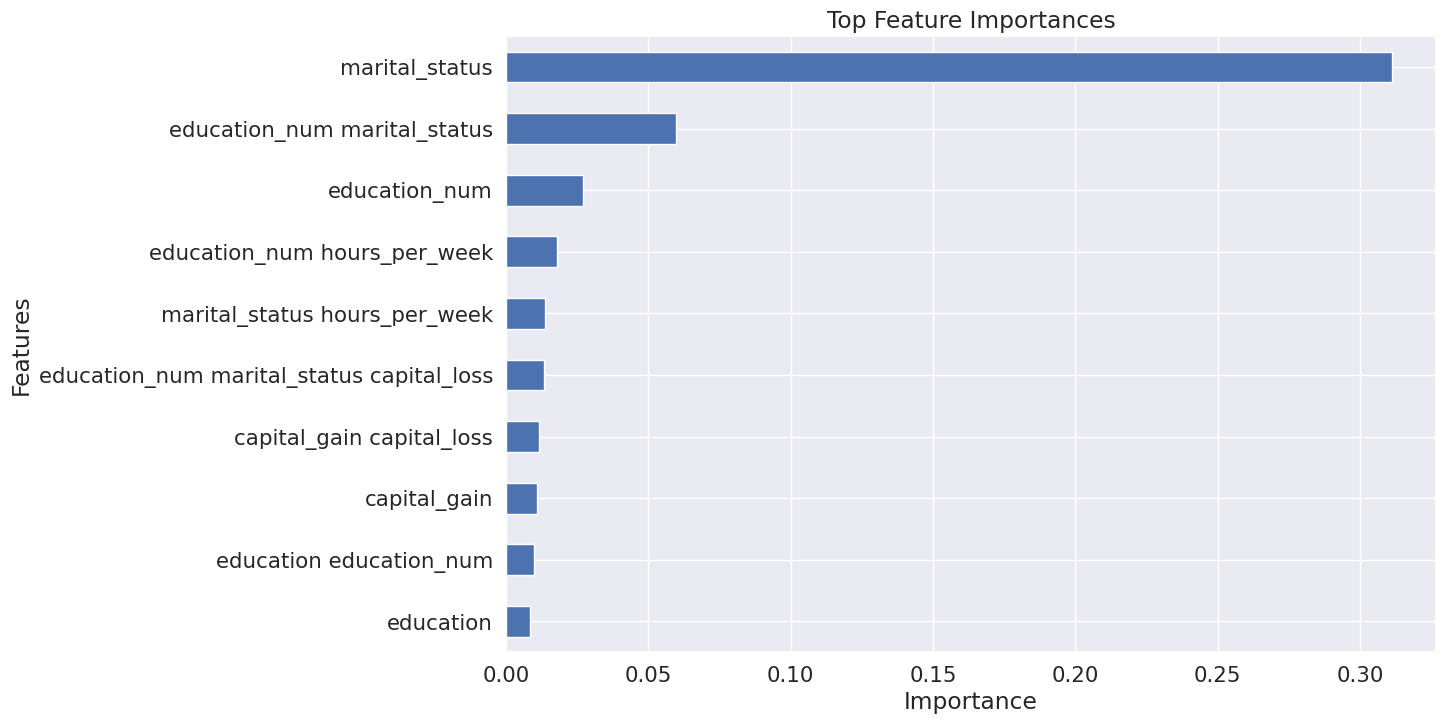

In [ ]:
# Retrieve the best estimator from the grid search
best_model = grid_search_XG.best_estimator_

# If the best estimator is a pipeline, retrieve the XGBClassifier step
if isinstance(best_model, Pipeline):
    xgb_model = best_model.named_steps['model']
else:
    xgb_model = best_model

# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Get the feature names from the polynomial features
feature_names = best_model.named_steps['poly'].get_feature_names_out()

# Create a pandas Series to hold the feature importances and names, and sort it
importances_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
importances_series[:10].plot(kind='barh')
plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

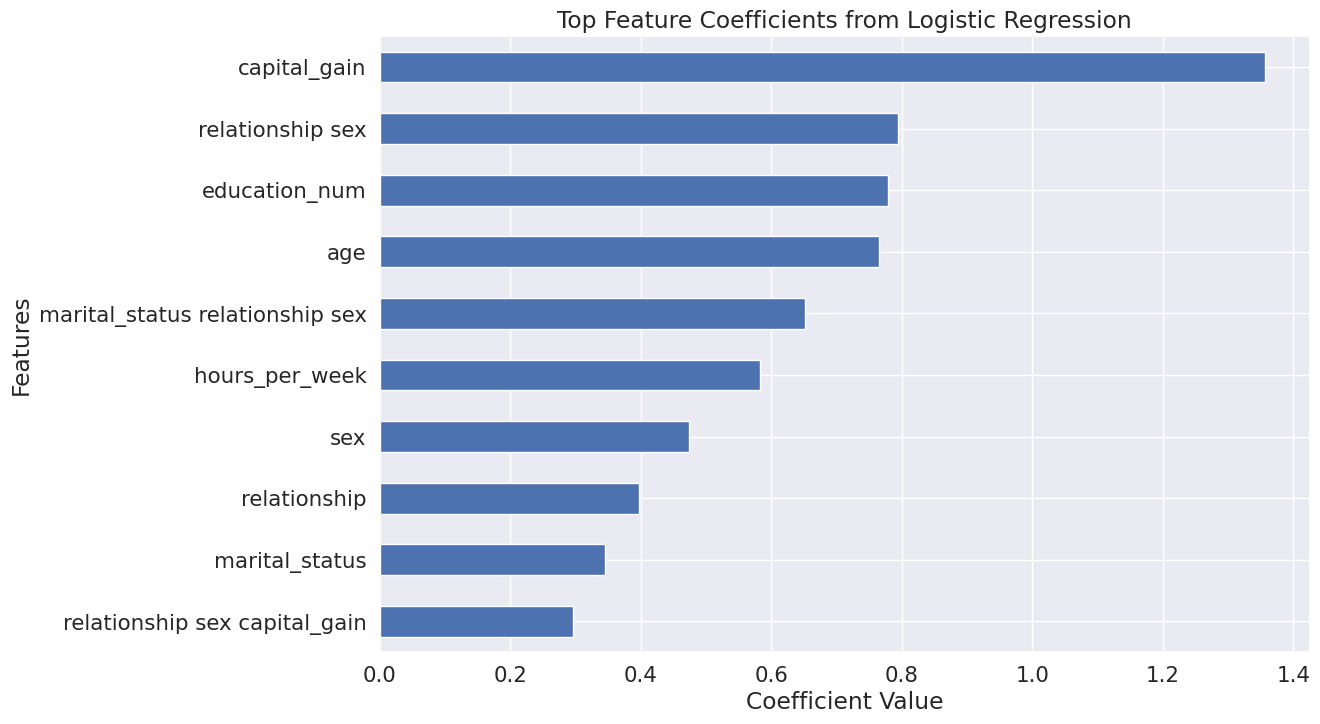

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming grid_search is your GridSearchCV object with a fitted logistic regression pipeline
best_model = grid_search.best_estimator_

# If the best estimator is a pipeline, retrieve the LogisticRegression step
logistic_model = best_model.named_steps['model']

# Get the coefficients from the logistic model
coefficients = logistic_model.coef_[0]  # [0] to get the coefficients for the first class in case of multi-class

# Get the feature names from the polynomial features
feature_names = best_model.named_steps['poly'].get_feature_names_out(input_features=X.columns)

# Create a pandas Series to hold the coefficients and feature names, and sort it
coefficients_series = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# Plot the coefficients
plt.figure(figsize=(12, 8))
coefficients_series[:10].plot(kind='barh')  # Adjust number as needed
plt.title('Top Feature Coefficients from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score


# Load the test data
test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows=1, header=None)

# Apply the same column labels as the training data
test.columns = col_labels

test['wage_class']=np.where(test['wage_class']== ' >50K.',1,0)
test['native_country']=np.where(test['native_country']==' United-States',1,0)
test['workclass']=np.where(test['workclass']==' Private',1,0)
test['sex']=np.where(test['sex']==' Male',1,0)
test['race']=np.where(test['race']==' White',1,0)
test['education']=test['education'].map(education_mapping)
test['relationship']=test['relationship'].map(relationship_ordered)
test['occupation']=test['occupation'].map(occupation_ordered)
#transform marital status and concatenate some classes to reduce distinct classes
test['marital_status']=test['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced',
                                                         ' Divorced':'Divorced',
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })
test['marital_status']=test['marital_status'].map(marital_ordered)
test.drop('fnlwgt',axis=1,inplace=True)
scaled_features_test=scaler.transform(test.drop('wage_class',axis=1))
scaled_features_test=pd.DataFrame(scaled_features_test, columns=test.drop('wage_class',axis=1).columns)

final_test=pd.concat([scaled_features_test,test['wage_class']],axis=1)

# Predict on the test set
test_predictions = grid_search.predict(scaled_features_test)

# Evaluate the model
test_accuracy = accuracy_score(test['wage_class'], test_predictions)
print(f"Test Set Accuracy: {test_accuracy}")

# Predict on the test set
test_predictions = grid_search_XG.predict(scaled_features_test)

# Evaluate the model
test_accuracy = accuracy_score(test['wage_class'], test_predictions)
print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 0.7911676186966402
Test Set Accuracy: 0.8407960199004975


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# Make predictions on the test data
logreg_predictions = logreg_model.predict(X_test)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f"Logistic Regression Test Accuracy: {logreg_accuracy}")


Logistic Regression Test Accuracy: 0.8175174751112052
